In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
import numpy as np
import scipy.optimize as optimize
import scipy.fftpack as fft
import scipy.linalg as linalg
from scipy.stats import linregress

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from BandPass2 import *
from fitFunctions import *
from partialfitting import *
from tqdm import *
from fitphases import *
from fitGammaRatio import *
from chi2 import *
from corrphase import *
from corr2Pi import *

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 15

/home/jean/miniconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jean/miniconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jean/miniconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [46]:
for i in range(5):
    times = np.arange( 1, 500*1000, 1 )/1000
    sig = 0.39770392*np.sin(2*np.pi*1.554*times) + 0.08523947*np.sin(2*np.pi*15.008*times)
    sig = sig + np.random.normal(0, 1e-3, size=len(sig))
    np.savetxt('/home/jean/RomalisResearch/FakeData/18-12-10/fakedata'+str(i)+".txt", sig)

In [51]:
#dirName = "/home/jean/RomalisResearch/ncrescini/18-10-30 1/" # Directory with data
dirName = "/home/jean/RomalisResearch/Data/18-12-15/" # Directory with data
#dirName = "/home/jean/RomalisResearch/FakeData/18-12-10/" # Directory with data
files = [f for f in os.listdir(dirName) if f.endswith('.txt')]
gHe = 20378.9
gNe = 2*np.pi*336.1
gRatio = gHe/gNe

ks1 = 6 # First file index
ks2 = 6 # Last file index
n_ave = 1 # Number of points to average over

dt = 1e-3*n_ave
Fs = 1/dt
D1Start = 20 # Start of first detection (currently only uses this)
D1EndTimes = [500] # End of first detection (currently only uses this)
D2Start = 200 # Start of second detection (currently doesn't use this)
D2EndTimes = [240] # End of second detection (currently doesn't use this)
absSigma = True

delta_t = 2/1.56 # Time length of a subsection

In [42]:
phi1_fit_arr = np.empty((ks2+1-ks1, 2))
phi2_fit_arr = np.empty((ks2+1-ks1, 2))
phi1_fiterr_arr = np.empty((ks2+1-ks1, 2))
phi2_fiterr_arr = np.empty((ks2+1-ks1, 2))
chi21_arr = np.empty(ks2+1-ks1)
chi22_arr = np.empty(ks2+1-ks1)
r_arr = np.empty(ks2+1-ks1)

phi1_arr_all = []
phi1_fitresults_arr = []
phi2_arr_all = []
phi2_fitresults_arr = []
phi1_fitresults_arr = []
phi1_err_all = []
phi2_err_all = []

for k_ind in range(ks1, ks2+1):
    print(k_ind)
    k = k_ind - ks1 # file number
    paraOut_arr, errtout_arr, dataPar_x, dataPar_y, datafit = initialfitting(k_ind, k, n_ave, dirName, files, dt, Fs, D1Start, D1EndTimes, D2Start, D2EndTimes, delta_t)
    phi1_err = errtout_arr[:,5]; phi2_err = errtout_arr[:,2]
    times = np.mean(dataPar_x, axis=1)
    np.save('times', times)
    phi1_arr, phi2_arr, fit_freq1, fit_freq2, fit_err1, fit_err2 = correctPhases(times, paraOut_arr, errtout_arr)
    phi1_fit_results, phi1_fit_arr[k], phi1_fiterr_arr[k], chi21_arr[k], phi2_fit_results, phi2_fit_arr[k], phi2_fiterr_arr[k], chi22_arr[k] = fitPhases(times, phi1_arr, phi1_err, phi2_arr, phi2_err, absSigma)
    
    r_arr[k] = fitGammaRatio(phi1_arr, phi2_arr, gHe/gNe)
    phi1_arr_all.append(phi1_arr)
    phi2_arr_all.append(phi2_arr)
    phi1_err_all.append(phi1_err)
    phi2_err_all.append(phi2_err)
    phi1_fitresults_arr.append(phi1_fit_results)
    phi2_fitresults_arr.append(phi2_fit_results)

phi1_fitresults_arr = np.array(phi1_fitresults_arr)
phi1_arr_all = np.array(phi1_arr_all)
phi2_fitresults_arr = np.array(phi2_fitresults_arr)
phi2_arr_all = np.array(phi2_arr_all)
phi1_err_all = np.array(phi1_err_all)
phi2_err_all = np.array(phi2_err_all)

6
Sigma: 0.000646651416575255
15.01468265748911 1.5560603442668743


/home/jean/RomalisResearch/pulsed_fitter_current/fitFunctions.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  s_sq = np.sum( ((fitval-y)/sigma)**2 )/(len(x) - 2)


7
Sigma: 0.000854516131275955
15.014811725461387 1.5560732554297774
8
Sigma: 0.0008084985725995447
15.014768719275988 1.5560690968265127
9
Sigma: 0.0007938315891964371
15.014759176419654 1.556068267637424
10
Sigma: 0.0005943376204379463
15.014664255474305 1.5560584648056452


In [43]:
cp_fit_arr = np.empty((ks2+1-ks1, 2))
cp_fiterr_arr = np.empty((ks2+1-ks1, 2))
cpchi2_arr = np.empty(ks2+1-ks1)
cp_arr_all = []
cp_fitresults_arr = []
cp_err_all = []

for k_ind in range(ks1, ks2+1):
    k = k_ind - ks1 # file number
    cp_val, cp_err, cp_fit_results, cp_fit_arr[k], cp_fiterr_arr[k], cpchi2_arr[k] = corrphase(times, phi1_arr_all[k], phi2_arr_all[k], phi1_err_all[k], phi2_err_all[k], np.mean(r_arr[np.abs(r_arr-r_arr[0])<0.00005]), absSigma)

    cp_arr_all.append(cp_val)
    cp_err_all.append(cp_err)
    cp_fitresults_arr.append(cp_fit_results)

cp_arr_all = np.array(cp_arr_all)
cp_fitresults_arr = np.array(cp_fitresults_arr)
cp_err_all = np.array(cp_err_all)

In [99]:
#np.savez("pulsed_fitter_current_results", phi1_arr_all=phi1_arr_all, phi2_arr_all=phi2_arr_all, phi1_err_all=phi1_err_all, phi2_err_all=phi2_err_all, cp_arr_all=cp_arr_all, cp_fit_arr=cp_fit_arr, cp_err_all=cp_err_all, cp_res_all=(cp_arr_all[i,:] - cp_fitresults_arr[i,:]))

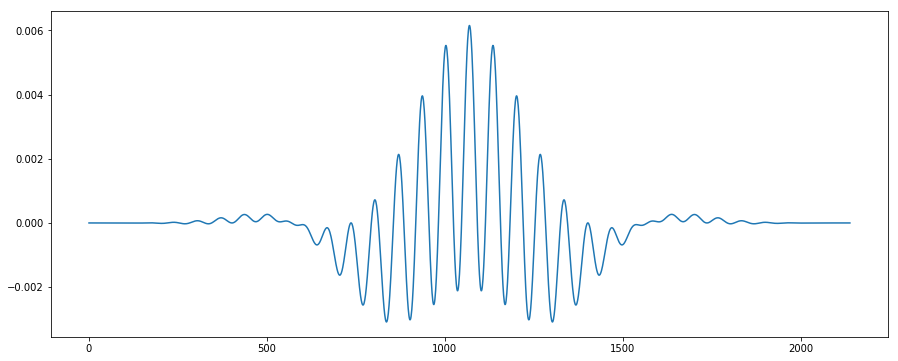

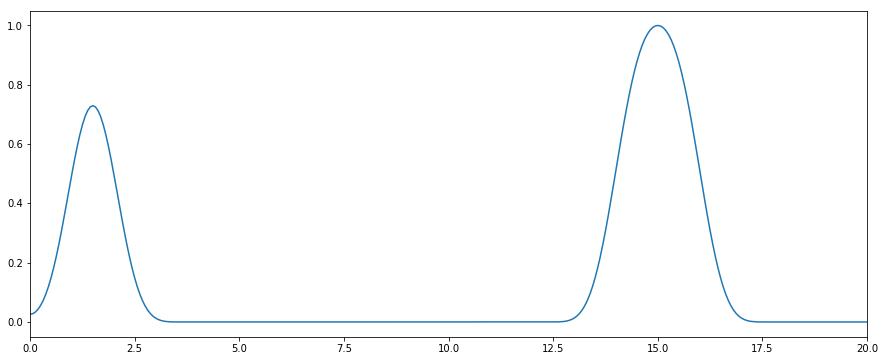

ValueError: in1 and in2 should have the same dimensionality

In [23]:
datafit2 = [ np.arange(len(np.loadtxt(dirName+files[0])[40000:90000]))*dt, np.loadtxt(dirName+files[0])[40000:90000] ]
nyq = 1/dt/2
width = 3.0/nyq
ripple_db = 100.0
N, beta = signal.kaiserord(ripple_db, width)
d = signal.firwin(N, [ 1e-15/nyq, 1/nyq, 2/nyq, 14/nyq, 16/nyq ], window=('kaiser', beta))
freqz = signal.freqz(d, worN=8000)[1]
d = d/max(np.abs(freqz))
plt.plot(d)
plt.show()
freqz = signal.freqz(d, worN=8000)
plt.plot(freqz[0]/np.pi * nyq, np.absolute(freqz[1]))
plt.xlim(0,20)
plt.show()
fftd = getfft(d, dt)
datafit2[1] = signal.convolve(datafit2[1], d, mode='same', method='auto')
fftarr = np.fft.fft(datafit2[1])
P2 = np.abs(fftarr/len(datafit2[1]))
plt.axvline(.8, ls="--", c="grey", alpha=0.5)
plt.axvline(15.008, ls="--", c="grey", alpha=0.5)
plt.plot(1/(dt) * np.arange(0, int(len(datafit2[1])))/len(datafit2[1]), P2)
plt.yscale("log")
plt.xlim(0,20)
plt.xlabel("Hz")
plt.show()
f, P_den = signal.welch(datafit2[1], 1/dt, nperseg=2**15)
print(np.sqrt(np.mean(P_den[np.argmin(np.abs(f-14.5)):np.argmin(np.abs(f-14.6))]*(1/(2*dt))))*1e3)
plt.plot(f, P_den)
plt.yscale("log")
plt.xlim(0,20)
plt.xlabel("Hz")
plt.show()
datafit2 = [ np.arange(len(np.loadtxt(dirName+files[0])[40000:90000]))*dt, np.loadtxt(dirName+files[0])[40000:90000] ]
f, P_den = signal.welch(datafit2[1], 1/dt, nperseg=2**15)
print(np.sqrt(np.mean(P_den[np.argmin(np.abs(f-14.5)):np.argmin(np.abs(f-14.6))]*(1/(2*dt))))*1e3)
plt.plot(f, P_den/(2*dt))
plt.yscale("log")
plt.xlim(0,20)
plt.xlabel("Hz")
plt.show()

In [ ]:
data = np.loadtxt(dirName+files[5])
dt = 1e-3
datafit2 = [ data[12000:500000,0], data[12000:500000,1] ]
datafit, err = BandPassFilter(datafit, dt, [], 200, 100)
fftarr = np.fft.fft(datafit2[1])
P2 = np.abs(fftarr/len(datafit2[1]))
# P1 = P2[:int(len(datafit[1])/2)]
# P1[1:-1] = 2*P1[1:-1]
plt.axvline(1.5554, ls="--", c="grey", alpha=0.5)
plt.axvline(15.008, ls="--", c="grey", alpha=0.5)
plt.plot(1/(dt) * np.arange(0, int(len(datafit2[1])))/len(datafit2[1]), P2)
plt.yscale("log")
plt.xlim(0,20)
plt.xlabel("Hz")
plt.show()

5.302276951688344e-05


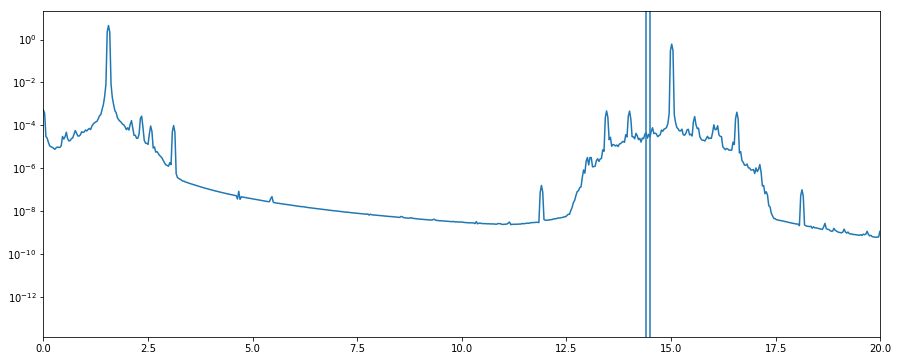

In [76]:
# f, P_den = signal.welch(dataPar_y.flatten(), 1/dt, window='hamming', nperseg=2**15)
# plt.axhline(np.sqrt(P_den[np.argmin(np.abs(14.8-f))]), c="black")
# plt.plot(f, np.sqrt(P_den))
f, P_den = signal.welch(dataPar_y.flatten(), 1/dt, nperseg=2**15)
plt.plot(f, np.sqrt(P_den))
plt.xlim(0,20)
plt.axvline(14.4)
plt.axvline(14.5)
plt.yscale("log")
sigma = np.sqrt(P_den[np.argmin(np.abs(f-14.8))])
print((sigma))

Text(0,0.5,'Signal [V]')

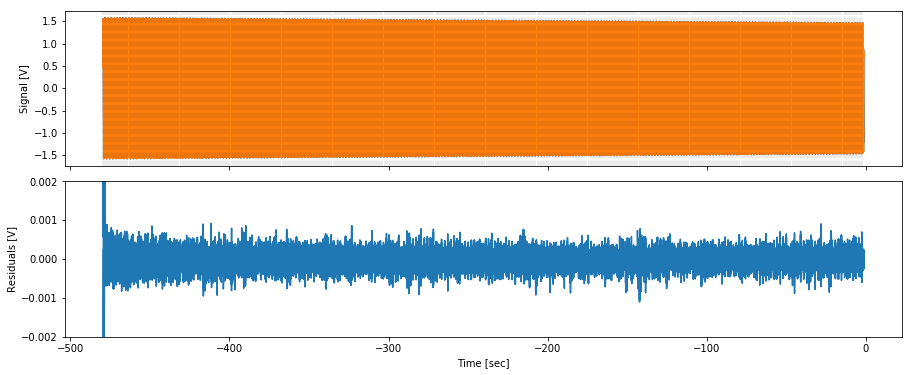

In [50]:
fig, ax = plt.subplots(2,1)
ax[0].plot(dataPar_x.flatten(), dataPar_y.flatten())
ax[0].plot(dataPar_x.flatten(), datafit, ls="-")
#ax.set_xlim(-450, -300)
for i in dataPar_x:
    ax[0].axvline(i[0], color="black", alpha=0.1, ls="--")
ax[1].plot(dataPar_x.flatten(), datafit-dataPar_y.flatten())
ax[1].set_ylim(-2e-3,2e-3)
# fft_arr,f  = getfft(dataPar_y.flatten()-datafit, dt)
# ax[2].plot(f, fft_arr)
# ax[2].set_xlim(0,20)
#plt.plot(phi1_err)
plt.setp([a.get_xticklabels() for a in [fig.axes[0]]], visible=False)
fig.subplots_adjust(hspace=0.1)
ax[1].set_xlabel("Time [sec]")
ax[1].set_ylabel("Residuals [V]")
ax[0].set_ylabel("Signal [V]")

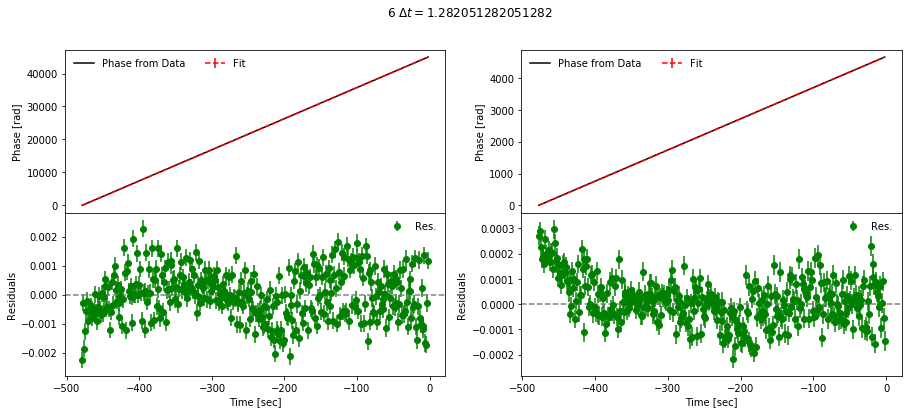

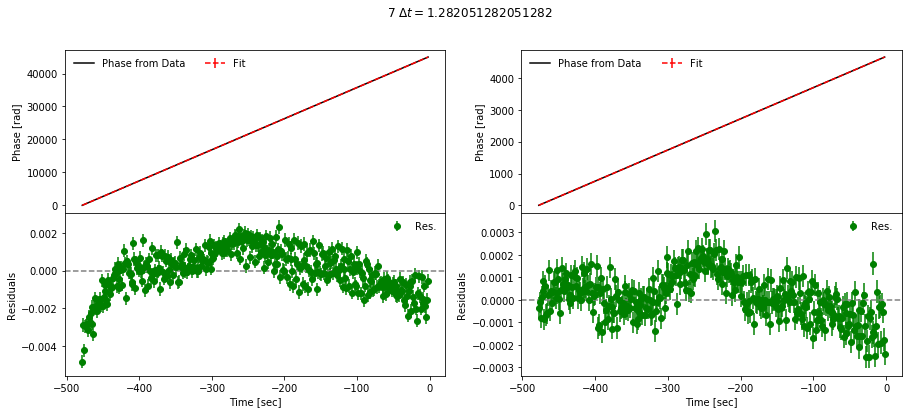

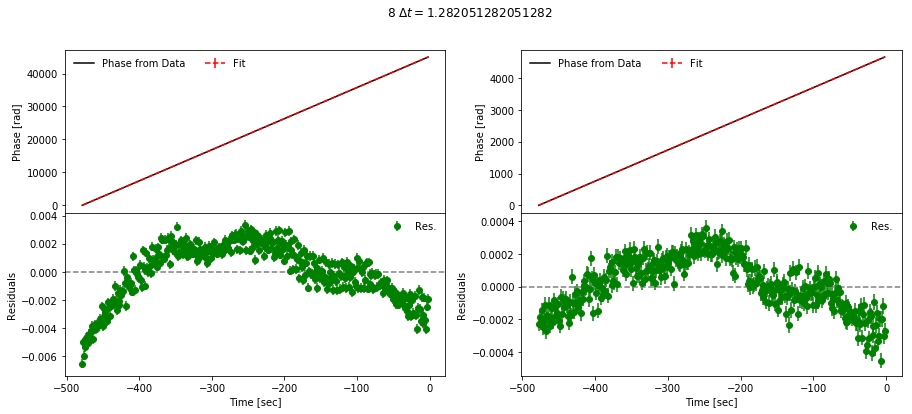

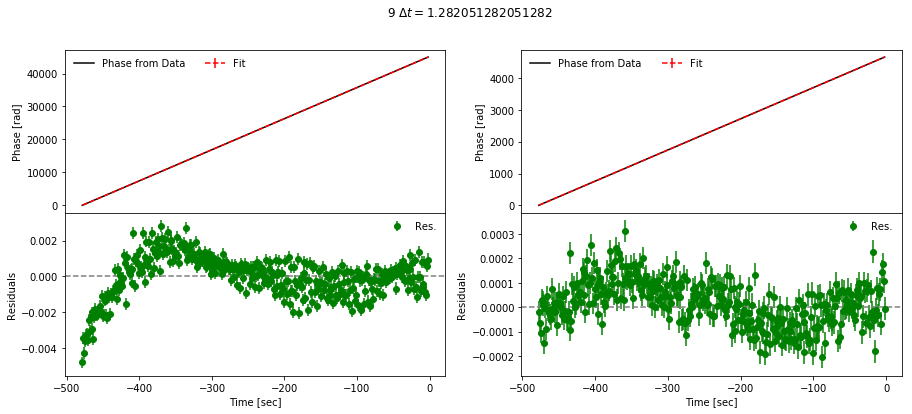

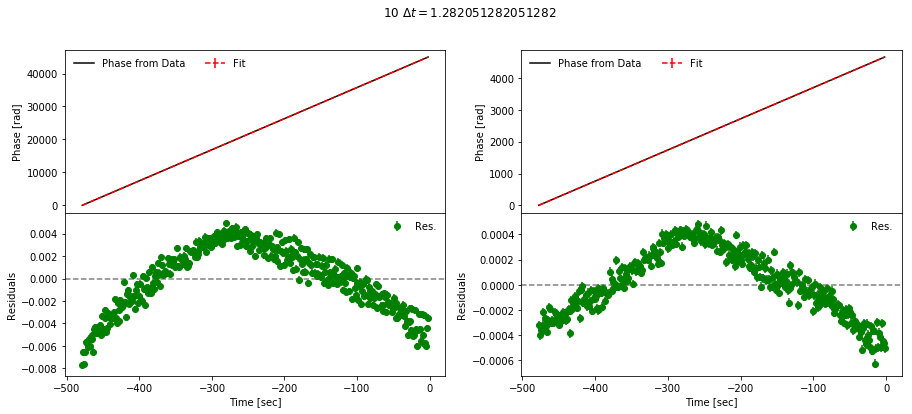

In [44]:
for k_ind in range(ks1, ks2+1):
    i = k_ind - ks1
    mpl.rcParams['figure.figsize'] = [15.0, 6.0]
    f, ax_arr = plt.subplots(2, 2)
    f.suptitle(str(k_ind)+' $\Delta t = '+str(delta_t)+"$")
    ax_arr[0,0].plot( times, phi1_arr_all[i], c="black", label="Phase from Data")
    ax_arr[0,0].errorbar( times, phi1_fitresults_arr[i], (phi1_fiterr_arr[i][1]+phi1_fiterr_arr[i][0]*times), c="red", ls="--", label="Fit")
    ax_arr[1,0].errorbar( times, (phi1_arr_all[i] - phi1_fitresults_arr[i]), phi1_err_all[i], fmt = 'o', c="green", label="Res.")
    ax_arr[1,0].axhline(0, ls="--", c="grey")
    ax_arr[0,0].legend(frameon=False, ncol=2 )
    ax_arr[1,0].legend(frameon=False, ncol=2 )
    ax_arr[1,0].set_xlabel("Time [sec]")
    ax_arr[0,0].set_ylabel("Phase [rad]")
    ax_arr[1,0].set_ylabel("Residuals")
    f.subplots_adjust(hspace=0)

    ax_arr[0,1].plot( times, phi2_arr_all[i], c="black", label="Phase from Data")
    ax_arr[0,1].errorbar( times, phi2_fitresults_arr[i], (phi2_fiterr_arr[i][1]+phi2_fiterr_arr[i][0]*times), c="red", ls="--", label="Fit")
    ax_arr[1,1].errorbar( times[1:], (phi2_arr_all[i] - phi2_fitresults_arr[i])[1:], phi2_err_all[i, 1:], fmt = 'o', c="green", label="Res.")
    ax_arr[1,1].axhline(0, ls="--", c="grey")
    ax_arr[0,1].legend(frameon=False, ncol=2 )
    ax_arr[1,1].legend(frameon=False, ncol=2 )
    ax_arr[1,1].set_xlabel("Time [sec]")
    ax_arr[0,1].set_ylabel("Phase [rad]")
    ax_arr[1,1].set_ylabel("Residuals")
    #ax_arr[1,1].set_ylim(-2e-4, 3e-4)
    plt.setp([a.get_xticklabels() for a in [f.axes[1], f.axes[0]]], visible=False)
    f.subplots_adjust(hspace=0)

Text(0.5,1,'Corrected Phase')

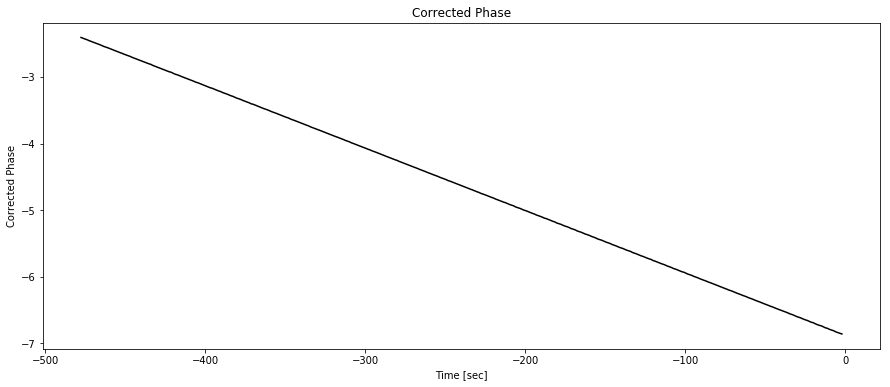

In [45]:
plt.figure();
plt.plot( times[1:], phi1_arr[1:] - gHe/gNe*phi2_arr[1:], c="black", label="Corrected Phase from Data")
plt.xlabel("Time [sec]")
plt.ylabel("Corrected Phase")
plt.title("Corrected Phase")

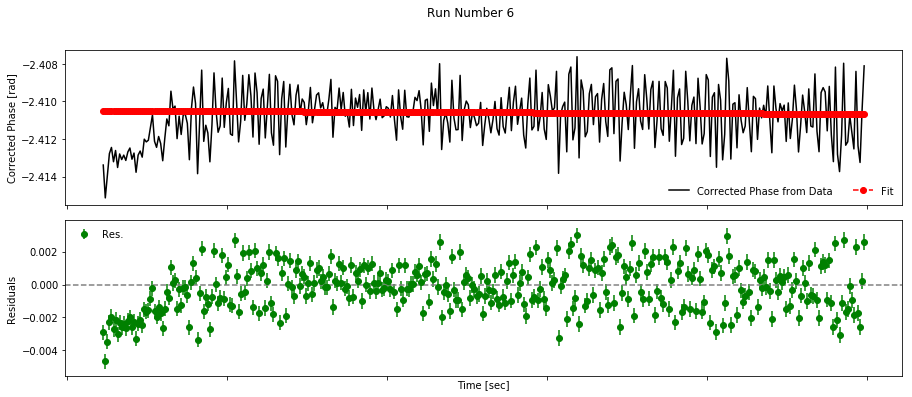

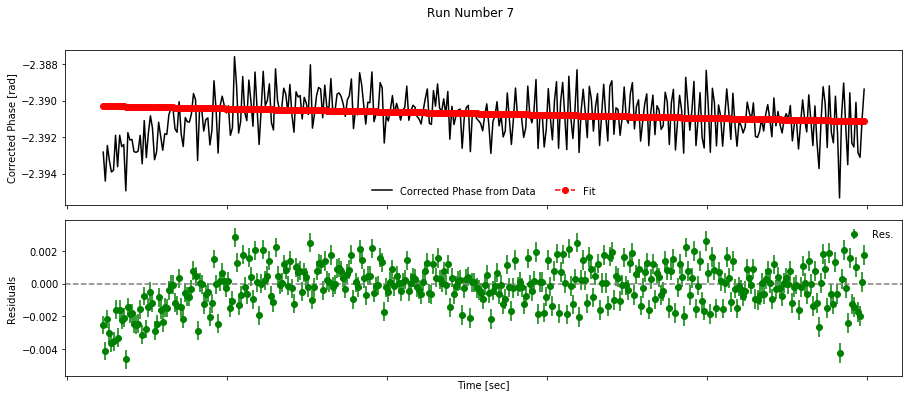

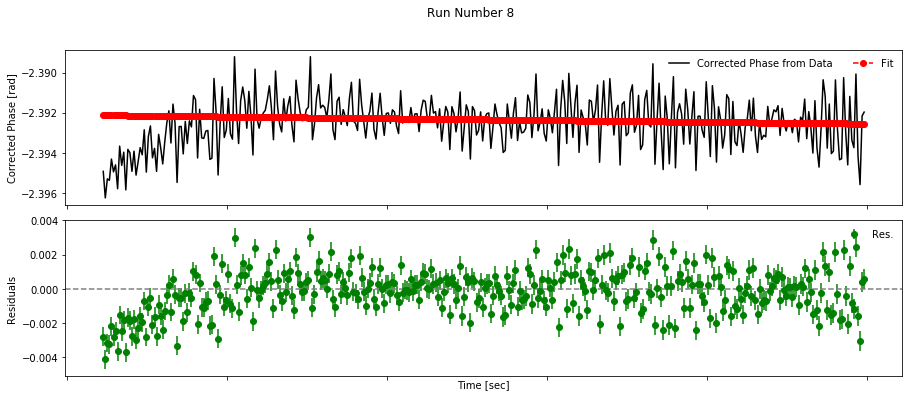

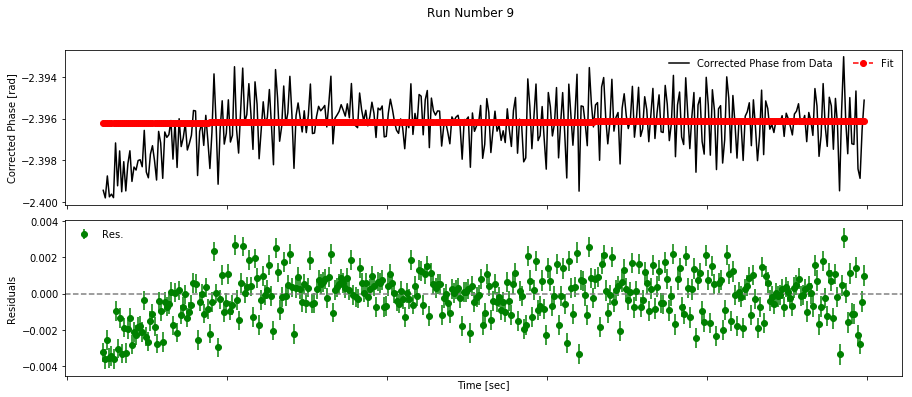

In [46]:
for k_ind in range(ks1, ks2):
    i = k_ind - ks1
    plt.figure();
    f, ax_arr = plt.subplots(2, 1)
    f.suptitle("Run Number " + str(k_ind) )
    ax_arr[0].plot( times[1:], cp_arr_all[i,1:], c="black", label="Corrected Phase from Data")
    #ax_arr[0].errorbar( times, cp_fitresults_arr[i], np.amax( (np.abs(cp_fiterr_arr[i][1]+cp_fiterr_arr[i][0]*times), np.abs(cp_fiterr_arr[i][1]-cp_fiterr_arr[i][0]*times)), axis=0), c="red", ls="--", label="Fit", marker="o")
    ax_arr[0].errorbar( times[1:], cp_fitresults_arr[i,1:], c="red", ls="--", label="Fit", marker="o")
    ax_arr[1].errorbar( times[1:], (cp_arr_all[i,1:] - cp_fitresults_arr[i,1:]), cp_err_all[i,1:], fmt="o", c="green", label="Res.")
    cpchi2_arr[i] = (np.sum(((cp_arr_all[i,1:] - cp_fitresults_arr[i,1:])/cp_err_all[i,1:])**2/(len(cp_arr_all[i,1:])-2)))
    ax_arr[1].axhline(0, ls="--", c="grey")
    ax_arr[0].legend(frameon=False, ncol=2 )
    ax_arr[1].legend(frameon=False, ncol=2 )
    ax_arr[1].set_xlabel("Time [sec]")
    ax_arr[0].set_ylabel("Corrected Phase [rad]")
    ax_arr[1].set_ylabel("Residuals")
    #ax_arr[1].set_ylim(-3e-3, 3e-3)
    plt.setp([a.get_xticklabels() for a in [f.axes[1], f.axes[0]]], visible=False)
    f.subplots_adjust(hspace=0.1)

Text(0.5,0,'Run Number')

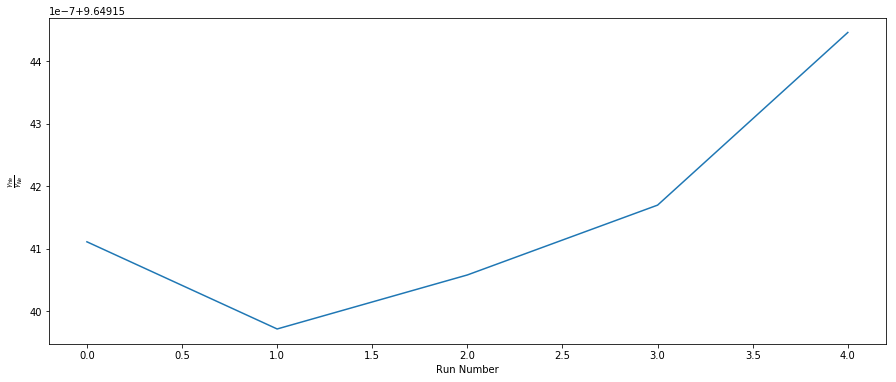

In [47]:
plt.plot(r_arr[np.abs(r_arr-r_arr[0])<0.00008])
plt.ylabel("$\\frac{\\gamma_{He}}{\\gamma_{Ne}}$")
plt.xlabel("Run Number")

Text(0.5,1,'$\\omega_{corr} \\, \\chi^2$ histogram')

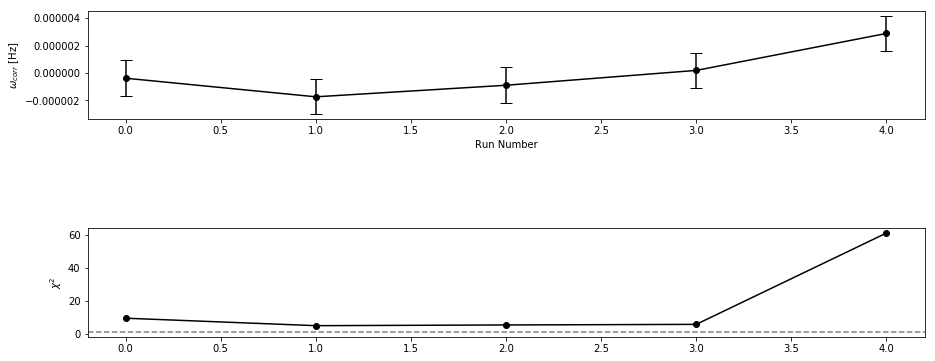

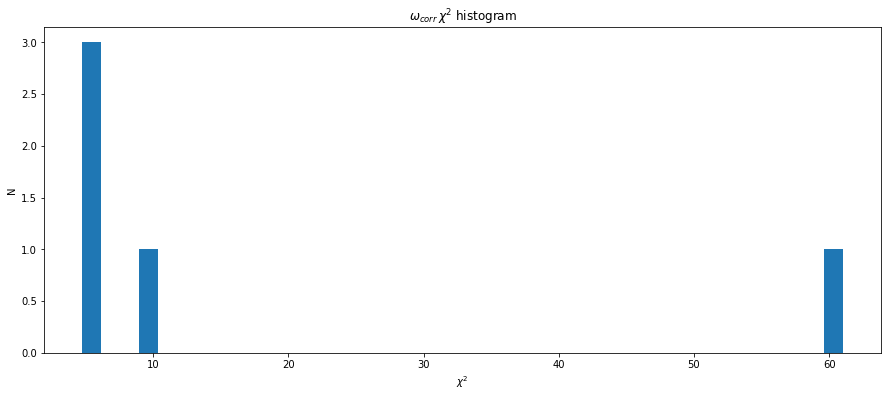

In [48]:
f, ax_arr = plt.subplots(2, 1)
ax_arr[0].errorbar(np.arange(len(cp_fit_arr[cp_fit_arr[:,0]<0.0002,0])), cp_fit_arr[cp_fit_arr[:,0]<0.0002,0], cp_fiterr_arr[cp_fit_arr[:,0]<0.0002,0], fmt="o", ls="-", c="black", markersize=6, capsize=6)
ax_arr[0].set_ylabel("$\omega_{corr}$ [Hz]")
#ax_arr[0].set_ylim(-4.5e-5,-3.1e-5)
ax_arr[1].plot(np.arange(len(cp_fit_arr)), cpchi2_arr, marker=".", markersize=12, color="black")
ax_arr[1].set_ylabel("$\chi^2$")
ax_arr[0].set_xlabel("Run Number")
ax_arr[1].axhline(1, ls="--", c="grey")
#ax_arr[1].set_ylim(0,3)
#plt.setp([a.get_xticklabels() for a in [f.axes[0]]], visible=False)
f.subplots_adjust(hspace=1)
plt.figure()
plt.hist(cpchi2_arr[cpchi2_arr<100], bins=40)
plt.xlabel("$\chi^2$")
plt.ylabel("N")
plt.title("$\omega_{corr} \, \chi^2$ histogram")

In [49]:
print(np.mean(cp_fit_arr[:,0]))
print(np.std(cp_fit_arr[:,0]))

2.254962458364819e-08
1.5735980413152723e-06
